# Imports

In [68]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import ast
import os
import json
import hashlib

from scripts.evaluation_metrics import *
from scripts.random_baseline import random_baseline
from scripts.retrieval_by_similarity import retrieve_n_songs_by_similarity
from scripts.relevance_computation import compute_weighted_jaccard
from scripts.tradeoff_evaluation import evaluate_tradeoffs

# Parameters

In [69]:
np.random.seed(42)
sampling_size = 200
N = 100
similarity_metric = 'cosine'
label_weights = [0.5, 0.5]

# Define model parameters
params = {
    'objective': 'rank:ndcg',
    'eta': 0.0001,
    'max_depth': 4,
    'min_child_weight': 20,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'lambda': 10.0,
    'alpha': 20.0,
    'eval_metric': 'ndcg',
    'seed': 42,
}

In [70]:
dataset = pd.read_csv("../public/data/merged_dataset.tsv", sep="\t")
dataset['parsed_tags'] = dataset['(tag, weight)'].apply(ast.literal_eval)

bert_embeddings_path = "dataset/id_lyrics_bert_mmsr.tsv"
bert_data = pd.read_csv(bert_embeddings_path, sep='\t')
dataset = pd.merge(dataset, bert_data, on='id')
feature_columns = bert_data.columns[1:]

dataset['normalized_popularity'] = (
    (dataset['popularity'] - dataset['popularity'].min())
    / (dataset['popularity'].max() - dataset['popularity'].min())
)


query_indices = np.random.choice(dataset.index, size=sampling_size, replace=False)


In [71]:
dataset.head()

,id,genre,artist,song,album_name,spotify_id,popularity,release,danceability,energy,...,759,760,761,762,763,764,765,766,767,normalized_popularity
0,01rMxQv6vhyE1oQX,"['rock', 'pop punk']",Against the Current,Chasing Ghosts,In Our Bones,4UYpnpm7ZDdo0hyyZNXSpl,41.0,2016,0.598,0.722,...,0.002565,0.049913,0.000948,0.002567,-0.010492,0.012738,0.014431,-0.027423,0.022325,0.465909
1,02ZnlCGZEbkfCDxo,"['pop', 'italian pop', 'latin', 'europop', 'am...",Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te,7eiFkQw3snYtC8jtHNUWvf,36.0,2001,0.569,0.727,...,-0.027509,0.035228,0.005406,-0.012837,-0.016159,-0.033687,-0.000188,-0.018019,-0.012388,0.409091
2,04OjszRi9rC5BlHC,"['experimental', 'folk', 'lo fi', 'freak folk'...",Grizzly Bear,Knife,Yellow House,4BmtCb6sdMqECAItGmFDvU,45.0,2006,0.226,0.400,...,0.003550,0.067611,-0.023377,0.001065,-0.006816,-0.020832,0.007907,-0.034614,-0.012186,0.511364
3,04iitW3ffa0mhpx3,"['pop', 'r b', 'hip hop', 'soul', 'rhythm and ...",Ne-Yo,Miss Independent,Year Of The Gentleman (Bonus Track Edition),34ceTg8ChN5HjrqiIYCn9Q,65.0,2008,0.673,0.683,...,0.024652,0.047910,-0.020096,-0.012123,-0.024786,-0.017319,0.017642,-0.032643,-0.009518,0.738636
4,04xUDjAYC14jsHyH,"['punk', 'emo', 'post hardcore', 'post punk', ...",Jawbreaker,Jinx Removing,24 Hour Revenge Therapy (Remastered),3H3RrT7cDpfXWromZIZEfv,25.0,2014,0.411,0.924,...,-0.003679,-0.019220,-0.021063,-0.000805,0.032793,-0.050547,0.010595,-0.034347,-0.008444,0.284091


# Preparing user-song interactions for ranking training

In [72]:
# Load interaction data
interaction_data = pd.read_csv("./dataset/userid_trackid_count_mmsr.tsv", sep="\t")

# Aggregate listens per song
song_interaction_summary = interaction_data.groupby('track_id').agg(
    total_listens=('count', 'sum'),   # Total number of times song was listened
    unique_users=('user_id', 'nunique')  # Number of unique users who listened
).reset_index()

In [73]:
scaler = MinMaxScaler()
song_interaction_summary[['normalized_listens', 'normalized_users']] = scaler.fit_transform(
    song_interaction_summary[['total_listens', 'unique_users']]
)
# Drop original columns that already included to the dataset
song_interaction_summary.drop(columns=['total_listens'], inplace=True)

In [74]:
song_interaction_summary.head()

,track_id,unique_users,normalized_listens,normalized_users
0,01rMxQv6vhyE1oQX,134,0.009188,0.006697
1,02ZnlCGZEbkfCDxo,381,0.016630,0.019133
2,04OjszRi9rC5BlHC,5028,0.139731,0.253109
3,04iitW3ffa0mhpx3,3432,0.090545,0.172751
4,04xUDjAYC14jsHyH,726,0.024622,0.036504


# Adding interactions data to dataset

In [75]:
dataset = dataset.merge(song_interaction_summary, left_on='id', right_on='track_id', how='left')

In [76]:
dataset.head()

,id,genre,artist,song,album_name,spotify_id,popularity,release,danceability,energy,...,763,764,765,766,767,normalized_popularity,track_id,unique_users,normalized_listens,normalized_users
0,01rMxQv6vhyE1oQX,"['rock', 'pop punk']",Against the Current,Chasing Ghosts,In Our Bones,4UYpnpm7ZDdo0hyyZNXSpl,41.0,2016,0.598,0.722,...,-0.010492,0.012738,0.014431,-0.027423,0.022325,0.465909,01rMxQv6vhyE1oQX,134,0.009188,0.006697
1,02ZnlCGZEbkfCDxo,"['pop', 'italian pop', 'latin', 'europop', 'am...",Laura Pausini,Tra Te E Il Mare,The Best of Laura Pausini - E Ritorno Da Te,7eiFkQw3snYtC8jtHNUWvf,36.0,2001,0.569,0.727,...,-0.016159,-0.033687,-0.000188,-0.018019,-0.012388,0.409091,02ZnlCGZEbkfCDxo,381,0.016630,0.019133
2,04OjszRi9rC5BlHC,"['experimental', 'folk', 'lo fi', 'freak folk'...",Grizzly Bear,Knife,Yellow House,4BmtCb6sdMqECAItGmFDvU,45.0,2006,0.226,0.400,...,-0.006816,-0.020832,0.007907,-0.034614,-0.012186,0.511364,04OjszRi9rC5BlHC,5028,0.139731,0.253109
3,04iitW3ffa0mhpx3,"['pop', 'r b', 'hip hop', 'soul', 'rhythm and ...",Ne-Yo,Miss Independent,Year Of The Gentleman (Bonus Track Edition),34ceTg8ChN5HjrqiIYCn9Q,65.0,2008,0.673,0.683,...,-0.024786,-0.017319,0.017642,-0.032643,-0.009518,0.738636,04iitW3ffa0mhpx3,3432,0.090545,0.172751
4,04xUDjAYC14jsHyH,"['punk', 'emo', 'post hardcore', 'post punk', ...",Jawbreaker,Jinx Removing,24 Hour Revenge Therapy (Remastered),3H3RrT7cDpfXWromZIZEfv,25.0,2014,0.411,0.924,...,0.032793,-0.050547,0.010595,-0.034347,-0.008444,0.284091,04xUDjAYC14jsHyH,726,0.024622,0.036504


# Further data preparation

In [77]:
def prepare_ltr_data(dataset, query_indices, feature_columns, user_interactions, similarity_metric, top_n=100):
    """
    Prepare the dataset for LambdaMART training using only Pandas DataFrames.

    Args
    ----
        dataset: Pandas DataFrame containing the full dataset.
        query_indices: Indices of query songs in the dataset.
        feature_columns: List of columns corresponding to features (e.g., BERT embeddings).
        user_interactions: DataFrame with user-song interactions (user_id, track_id).
        similarity_metric: Metric to retrieve top N similar songs.
        top_n: Number of top candidates to retrieve for each query.

    Returns
    -------
        ltr_data: Pandas DataFrame in the format required for LTR models.
    """
    ltr_data = []

    for query_index in tqdm(query_indices, desc="Preparing LTR data"):
        query_song = dataset.iloc[query_index]

        # Retrieve top N similar songs based on feature embeddings
        candidates = retrieve_n_songs_by_similarity(query_song, dataset, feature_columns, metric=similarity_metric, N=top_n)

        # Get users who interacted with the query song
        query_users = set(user_interactions[user_interactions['track_id'] == query_song['id']]['user_id'])

        # Compute user overlap between query song and candidate songs
        overlap_scores = []
        for candidate_id in candidates['id']:
            candidate_users = set(user_interactions[user_interactions['track_id'] == candidate_id]['user_id'])
            overlap_count = len(query_users & candidate_users)  # Number of users in common
            overlap_scores.append(overlap_count)

        # Assign relevance labels based on percentile rank of overlap scores
        candidates['overlap_score'] = overlap_scores
        candidates['percentile'] = candidates['overlap_score'].rank(pct=True)

        # Map overlap percentiles to discrete relevance labels
        candidates['relevance_label'] = candidates['percentile'].apply(
            lambda x: 3 if x > 0.90 else 2 if x > 0.75 else 1 if x > 0.50 else 0
        )

        # Add query_id and other necessary columns
        candidates = candidates.copy()  # Avoid modifying the original dataset
        candidates['query_id'] = query_song['id']

        # Select only the required columns for LambdaMART training
        ltr_data.append(candidates[['query_id', 'id', 'relevance_label'] + feature_columns.tolist()])

    # Concatenate all LTR rows into a single DataFrame
    return pd.concat(ltr_data, ignore_index=True)


def train_xgboost_ltr(data, params, feature_columns):
    """
    Train an XGBoost model for Learning-to-Rank.

    Args
    ----
        data: Pandas DataFrame containing the LTR data.
        feature_columns: List of feature column names.

    Returns
    -------
        XGBoost model trained for LTR.
    """
    # Prepare features, labels, and groups
    X = data[feature_columns].values
    y = data['relevance_label'].values
    groups = data['query_id'].values

    # Use train_test_split to split data while respecting group sizes
    X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
        X, y, groups, test_size=0.2, random_state=42, stratify=groups
    )

    # Define XGBoost DMatrices
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtrain.set_group(np.unique(groups_train, return_counts=True)[1])
    dtest = xgb.DMatrix(X_test, label=y_test)
    dtest.set_group(np.unique(groups_test, return_counts=True)[1])

    # Train the model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dtest, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=10,
    )

    return model

In [79]:
# # Prepare LTR Data
ltr_data = prepare_ltr_data(dataset, query_indices, feature_columns, interaction_data, similarity_metric, top_n=N)
ltr_data.to_csv(f"./lambdamart_tuned/ltr_data/ltr_data_{sampling_size}_{similarity_metric}_{N}.tsv", sep="\t", index=False)

Preparing LTR data: 100%|██████████| 200/200 [53:44<00:00, 16.12s/it]


In [59]:
# ltr_data = pd.read_csv(f"./lambdamart_tuned/ltr_data/ltr_data_{sampling_size}_{similarity_metric}_{N}.tsv", sep="\t")

In [81]:
print(ltr_data.head())

           query_id                id  relevance_label         0         1  \
0  EJCqZ5sqDgc5DsBE  dKgW8TWUQEkrWNxx                2  0.004046  0.093006   
1  EJCqZ5sqDgc5DsBE  zODMkQZR2uQ5hfNN                0 -0.007314  0.088537   
2  EJCqZ5sqDgc5DsBE  3A9xFYR9P4g77E8P                0 -0.030206  0.113647   
3  EJCqZ5sqDgc5DsBE  C3aPWP9mSNzUDfU8                0  0.005376  0.044247   
4  EJCqZ5sqDgc5DsBE  9gMC8bWdWmJ8Iayf                0  0.016487  0.081489   

          2         3         4         5         6  ...       758       759  \
0  0.032590 -0.007400 -0.012689  0.008428 -0.035186  ... -0.050389 -0.006997   
1  0.008578  0.023934 -0.008325  0.015109 -0.060778  ...  0.021050  0.016021   
2 -0.003120 -0.013228 -0.016542 -0.001514 -0.032143  ... -0.005538  0.030421   
3 -0.016097 -0.039827  0.002347  0.021880 -0.013956  ... -0.000038  0.037480   
4  0.032579 -0.017164 -0.005716  0.015158 -0.031576  ... -0.008070  0.001809   

        760       761       762       763       76

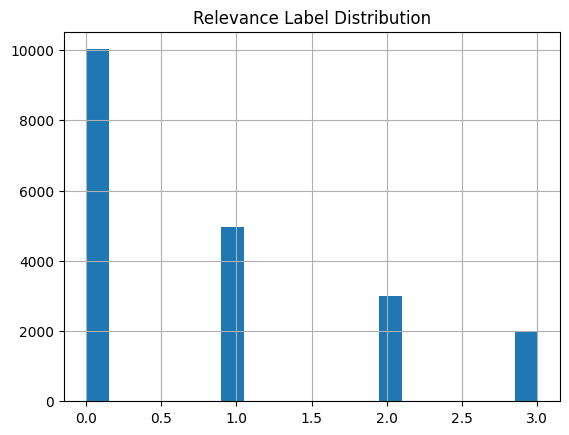

In [82]:
import matplotlib.pyplot as plt
ltr_data['relevance_label'].hist(bins=20)
plt.title('Relevance Label Distribution')
plt.show()

In [83]:
ltr_data.loc[ltr_data['relevance_label'] == 1, 'relevance_label']

15       1
17       1
20       1
23       1
26       1
        ..
19969    1
19973    1
19979    1
19986    1
19989    1
Name: relevance_label, Length: 4976, dtype: int64

In [84]:
# Train XGBoost LTR model
model = train_xgboost_ltr(ltr_data, params, feature_columns)

# Save the trained model
hash_input = str(len(dataset)) + str(feature_columns) + str(similarity_metric) + str(N) + str(sampling_size) + str(params) + str(label_weights)
params_hash = hashlib.md5(hash_input.encode()).hexdigest()
filename = f"lambdamart_ltr_bert_{params_hash[:5]}.json"
filepath = os.path.join("./lambdamart_tuned", filename)
    
model.save_model(filepath)

[0]	train-ndcg:0.43194	valid-ndcg:0.63669
[10]	train-ndcg:0.53818	valid-ndcg:0.67256
[20]	train-ndcg:0.55268	valid-ndcg:0.68230
[30]	train-ndcg:0.55938	valid-ndcg:0.68801
[40]	train-ndcg:0.56548	valid-ndcg:0.68718
[50]	train-ndcg:0.56269	valid-ndcg:0.68783
[60]	train-ndcg:0.56382	valid-ndcg:0.68826
[70]	train-ndcg:0.56306	valid-ndcg:0.68899
[80]	train-ndcg:0.56281	valid-ndcg:0.68991
[90]	train-ndcg:0.56577	valid-ndcg:0.69107
[100]	train-ndcg:0.56477	valid-ndcg:0.69031
[110]	train-ndcg:0.56705	valid-ndcg:0.68971
[120]	train-ndcg:0.56701	valid-ndcg:0.68983
[130]	train-ndcg:0.56875	valid-ndcg:0.69038
[136]	train-ndcg:0.57008	valid-ndcg:0.69035


# Recommendation to JSON

In [85]:
import json
from tqdm import tqdm
import xgboost as xgb

def generate_recommendations_with_lambdamart(
    dataset, 
    model_path, 
    feature_columns, 
    output_file, 
    N=100
):
    """
    Generate and store recommendations for each query song using LambdaMART.

    Args
    ----
        dataset (pd.DataFrame): The full dataset containing songs and features.
        model_path (str): Path to the pre-trained LambdaMART model file.
        feature_columns (list): List of feature column names for LambdaMART.
        output_file (str): Path to save the JSON output with recommendations.
        N (int): Number of top recommendations to generate for each query.
    """
    # Load the pre-trained LambdaMART model
    model = xgb.Booster()
    model.load_model(model_path)

    # Prepare the feature matrix for all candidates
    candidate_dmatrix = xgb.DMatrix(dataset[feature_columns].values)

    # Initialize recommendations dictionary
    recommendations_dict = {}

    # Generate recommendations for each query song
    for _, query_song in tqdm(dataset.iterrows(), total=len(dataset), desc="Generating Recommendations"):
        # Exclude the query song itself
        filtered_dataset = dataset[dataset['id'] != query_song['id']].copy()

        # Prepare the feature matrix for the filtered dataset
        filtered_dmatrix = xgb.DMatrix(filtered_dataset[feature_columns].values)

        # Generate scores for all candidates
        filtered_dataset['score'] = model.predict(filtered_dmatrix)

        # Retrieve top N recommendations based on score
        top_n_recommendations = (
            filtered_dataset.sort_values(by='score', ascending=False)
            .head(N)[['id', 'score']]
            .set_index('id')['score']
            .to_dict()
        )

        # Store recommendations for the query song
        recommendations_dict[query_song['id']] = top_n_recommendations

    # Save recommendations to JSON
    output_data = {
        "metadata": {
            "feature_space": "LambdaMART",
            "N": N,
            "similarity_metric": "LambdaMART"
        },
        "content": recommendations_dict
    }

    with open(output_file, 'w') as f:
        json.dump(output_data, f, indent=4)

    print(f"Recommendations saved to {output_file}")

In [87]:
hash_input = str(len(dataset)) + str(feature_columns) + str(similarity_metric) + str(N) + str(sampling_size) + str(params) + str(label_weights)
params_hash = hashlib.md5(hash_input.encode()).hexdigest()
filename = f"lambdamart_ltr_bert_{params_hash[:5]}.json"
filepath = os.path.join("./lambdamart_tuned", filename)

if not os.path.exists(filepath):
    print(f"File {filename} not found.")
    KeyError
    
output_file = f"../public/data/precomputed_systems/{params_hash[:5]}.json"

# Generate recommendations
generate_recommendations_with_lambdamart(
    dataset=dataset,
    model_path=filepath,
    feature_columns=feature_columns,
    output_file=output_file,
    N=100
)

Generating Recommendations: 100%|██████████| 5148/5148 [11:41<00:00,  7.33it/s]


Recommendations saved to ../public/data/precomputed_systems/ddbdb.json


# Metrics to JSON

In [91]:
def add_metrics_to_metadata(
    json_file, dataset, tags_column, popularity_column, N=10, weight_threshold=60
):
    """
    Compute and append evaluation metrics with updated diversity and normalized popularity
    to the metadata of an existing JSON file.

    Args
    ----
        json_file (str): Path to the JSON file with predictions.
        dataset (pd.DataFrame): Full dataset containing additional features like tags and popularity.
        tags_column (str): Column name for parsed tags in the dataset.
        popularity_column (str): Column name for popularity in the dataset.
        N (int): Number of top results to evaluate.
        weight_threshold (int): Minimum weight for tags to be considered for diversity.

    Returns
    -------
        None: Updates the JSON file in place.
    """
    # Load JSON file
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extract predictions
    predictions_dict = data["content"]

    # Convert predictions to DataFrame
    predictions = []
    for query_id, song_scores in predictions_dict.items():
        for song_id, score in song_scores.items():
            predictions.append({"query_id": query_id, "id": song_id, "score": score})
    predictions_df = pd.DataFrame(predictions)

    # Initialize metrics
    total_queries = predictions_df["query_id"].nunique()
    precision_list = []
    recall_list = []
    mrr_list = []
    ndcg_list = []
    total_diversity = 0
    total_popularity = 0

    # Min-max scaling for popularity
    min_popularity = dataset[popularity_column].min()
    max_popularity = dataset[popularity_column].max()

    for query_id in tqdm(predictions_df["query_id"].unique(), desc="Evaluating metrics"):
        # Get top-N predictions for the query
        top_n_predictions = (
            predictions_df[predictions_df["query_id"] == query_id]
            .sort_values(by='score', ascending=False)
            .head(N)
        )

        # Get relevant song IDs
        top_n_ids = top_n_predictions["id"].tolist()

        # Retrieve relevant rows from the dataset
        relevant_songs = dataset[dataset["id"].isin(top_n_ids)]
        query_song = dataset[dataset["id"] == query_id].iloc[0]
        query_tags = query_song[tags_column]

        relevant_ids = dataset[
            dataset[tags_column].apply(
                lambda tags: len(set(query_tags.keys()) & set(tags.keys())) > 0
            )
        ]["id"].tolist()

        # Compute traditional metrics
        precision_list.append(precision_at_k(top_n_ids, relevant_ids, k=N))
        recall_list.append(recall_at_k(top_n_ids, relevant_ids, k=N))
        mrr_list.append(mean_reciprocal_rank(top_n_ids, relevant_ids))
        ndcg_list.append(ndcg_at_k(top_n_ids, relevant_ids, k=N))

        # Diversity: Calculate the ratio of unique tags among retrieved songs to total tags in retrieved songs
        retrieved_tags_dicts = relevant_songs[tags_column]
        unique_tags = set()
        total_tags_in_retrieved = 0

        for tags_dict in retrieved_tags_dicts:
            for tag, weight in tags_dict.items():
                if weight >= weight_threshold:
                    unique_tags.add(tag)
                    total_tags_in_retrieved += 1

        normalized_diversity = (
            len(unique_tags) / total_tags_in_retrieved
            if total_tags_in_retrieved > 0
            else 0
        )
        total_diversity += normalized_diversity

        # Popularity: Compute normalized average popularity of retrieved songs
        avg_popularity = relevant_songs[popularity_column].mean()
        normalized_popularity = (
            (avg_popularity - min_popularity) / (max_popularity - min_popularity)
            if max_popularity > min_popularity
            else 0
        )
        total_popularity += normalized_popularity

    # Finalize metrics
    results = {
        "Precision@N": sum(precision_list) / total_queries,
        "Recall@N": sum(recall_list) / total_queries,
        "NDCG@N": sum(ndcg_list) / total_queries,
        "MRR": sum(mrr_list) / total_queries,
        "Div@N": total_diversity / total_queries,  # Average diversity per query
        "AvgPop@N": total_popularity / total_queries,  # Average popularity per query
    }

    # Update metadata with metrics
    data["metadata"].update(results)

    # Save updated JSON file
    with open(json_file, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Metrics added to metadata and saved to {json_file}")
    return predictions_df

In [92]:
hash_input = str(len(dataset)) + str(feature_columns) + str(similarity_metric) + str(N) + str(sampling_size) + str(params) + str(label_weights)
params_hash = hashlib.md5(hash_input.encode()).hexdigest()

# File path to precomputed recommendations
json_file = f"../public/data/precomputed_systems/{params_hash[:5]}.json"

# Columns for evaluation
tags_column = 'parsed_tags'
popularity_column = 'popularity'

# Add metrics to metadata
preds = add_metrics_to_metadata(
    json_file=json_file,
    dataset=dataset,
    tags_column=tags_column,
    popularity_column=popularity_column,
    N=100
)

Evaluating metrics: 100%|██████████| 5148/5148 [03:05<00:00, 27.76it/s]


Metrics added to metadata and saved to ../public/data/precomputed_systems/ddbdb.json


In [ ]:
preds

# Remove the scores for UI to handle ids properly

In [93]:
import json

def remove_scores_from_recommendations(input_file, output_file):
    """
    Remove scores from the recommendations JSON file, leaving only IDs.

    Args
    ----
        input_file (str): Path to the input JSON file with scores.
        output_file (str): Path to save the output JSON file without scores.
    """
    with open(input_file, 'r') as f:
        data = json.load(f)

    # Remove scores from the content
    for query_id, recommendations in data['content'].items():
        data['content'][query_id] = list(recommendations.keys())

    # Save the modified data to the output file
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Scores removed and saved to {output_file}")

# Example usage
hash_input = str(len(dataset)) + str(feature_columns) + str(similarity_metric) + str(N) + str(sampling_size) + str(params) + str(label_weights)
params_hash = hashlib.md5(hash_input.encode()).hexdigest()

# File path to precomputed recommendations
json_file = f"../public/data/precomputed_systems/{params_hash[:5]}.json"

remove_scores_from_recommendations(json_file, json_file)


Scores removed and saved to ../public/data/precomputed_systems/ddbdb.json
